In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV


In [59]:
df = pd.read_csv('customerGroups.csv')

In [60]:
# df.info()

In [61]:
df.describe()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,g1_11,g1_12,g1_13,g1_14,g1_15,g1_16,g1_17,g1_18,g1_19,g1_20,g1_21,g2_1,g2_2,g2_3,g2_4,g2_5,g2_6,g2_7,g2_8,g2_9,g2_10,g2_11,g2_12,g2_13,g2_14,g2_15,g2_16,g2_17,g2_18,g2_19,g2_20,g2_21,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,target
count,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.00000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.00000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000
mean,2.708779,14.424018,10.485650,24.909668,10.988066,13.412085,10.161027,10.745468,14.169033,3.251057,-3.423565,-0.172508,3.154143,3.043544,10.268756,4.736862,1.121263,1.159848,0.205070,0.058852,0.449405,4.809875,15.113897,10.018580,25.132477,11.025076,14.040634,10.633837,10.253323,13.500453,3.406798,-3.247130,0.159668,3.183453,3.050268,4.840590,1.151021,1.125410,0.205567,0.058207,0.448996,3.899359,1.88984,1.563595,1.558761,3.122356,0.183686,0.200906,0.183686,0.200906,1.945808,4.405438,-4.628248,-0.222810,-0.088369,-0.092296,0.111631,0.128399,6.498187,-6.830363,-0.332175,-0.029311,-0.006724,-0.004147,0.008827,0.00000,-0.228426,-0.103728,0.000408,1.917134,1.031722
std,1.857725,10.700787,8.384203,18.174948,5.635985,10.090030,7.495039,7.964247,9.866734,8.481210,8.580752,15.036306,0.931224,0.825628,3.760524,2.127352,0.580622,0.566745,0.273416,0.151767,0.139392,3.937164,10.836923,8.251602,18.190664,5.666965,10.205415,7.563664,7.831935,9.722428,8.750434,8.313375,15.025919,0.928835,0.823931,2.150843,0.588387,0.552912,0.273798,0.151470,0.139194,1.093160,0.22708,4.063520,4.057417,3.939467,0.387257,0.400708,0.387257,0.400708,1.217214,8.497254,9.093944,14.470732,7.466654,6.378463,6.343190,7.420718,12.175872,12.973601,21.498095,1.220752,1.068199,0.663238,0.683422,0.32287,3.390902,1.944419,0.092761,0.302175,0.731042
min,1.050000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-27.000000,-38.000000,-65.000000,0.000000,0.172875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.950000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-27.000000,-36.000000,-63.000000,0.000000,0.216094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000,0.00000,-10.000000,-10.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-28.000000,-47.000000,-63.000000,-33.000000,-29.000000,-28.000000,-40.000000,-39.000000,-74.000000,-101.000000,-4.684111,-4.319826,-2.512919,-3.118836,-2.00000,-15.202740,-9.181722,-0.750000,0.000000,0.000000
25%,1.667000,6.000000,4.000000,10.000000,6.000000,5.000000,4.000000,4.000000,6.000000,-2.000000,-8.000000,-8.250000,2.499106,2.493665,8.512643,3.389698,0.735749,0.780218,0.011054,0.001827,0.348935,2.500000,6.000000,3.000000,11.000000,6.000000,6.000000,4.000000,4.000000,5.000000,-2.000000,-8.000000,-8.000000,2.500000,2.500000,3.470612,0.760000,0.758589,0.011054,0.001827,0.347931,3.250000,1.74000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.901358,0.000000,-9.000000,-7.000000,-4.000000,-3.000000,-3.000000,-3.000000,-1.000000,-13.000000,-10.000000,-0.716407,-0.531224,-0.440407,-0.406811,0.00000,-2.222226,-1.293471,-0.054331,1.710000,0.000000
50%,2.150000,13.000000,9.000000,22.000000,11.000000,12.000000,9.000000,9.000000,13.00000

In [62]:
pd.set_option('display.max_columns', None)

In [63]:
df.head()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,g1_11,g1_12,g1_13,g1_14,g1_15,g1_16,g1_17,g1_18,g1_19,g1_20,g1_21,g2_1,g2_2,g2_3,g2_4,g2_5,g2_6,g2_7,g2_8,g2_9,g2_10,g2_11,g2_12,g2_13,g2_14,g2_15,g2_16,g2_17,g2_18,g2_19,g2_20,g2_21,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,target
0,4.50,1,3,4,5,1,1,4,6,0,-2,-2,2.505032,2.551406,6.240000,3.608000,0.744000,1.216000,0.003078,0.003028,0.578205,1.83,6,0,6,7,4,0,0,1,4,-1,3,2.888736,2.616855,5.552000,0.728000,0.160000,0.002994,0.002953,0.586149,3.50,1.97,-1,7,6,0,0,0,1,3.223605,1,-3,-2,0,1,4,2,1,-6,-5,-0.383704,-0.065449,0.584000,0.488000,0,-3.232000,-1.944000,-0.007944,1.76,2
1,2.20,24,22,46,10,24,28,18,22,-4,-4,-8,3.718983,3.882271,7.423435,5.048030,0.836178,1.975244,0.784882,0.019448,0.680013,2.80,34,14,48,10,25,16,16,24,9,-8,1,4.065822,4.042015,6.369385,1.511704,1.783791,0.784882,0.033373,0.498949,3.25,1.85,2,1,3,0,0,0,0,1.541039,10,-12,-2,0,12,2,-3,4,-13,-9,-0.346839,-0.159744,-0.947614,0.463540,0,-5.342174,-1.321355,0.181064,1.85,1
2,12.00,7,4,11,18,8,11,2,10,-3,-8,-11,2.244550,2.458087,11.091399,5.853005,0.730046,2.022004,0.043937,0.014264,0.527707,1.30,11,18,29,2,13,3,16,1,10,15,25,4.918483,4.050389,10.029408,2.489174,0.204741,0.022247,0.042004,0.567984,5.00,1.70,-5,10,5,0,0,0,1,2.049024,-11,-7,-18,7,-5,-1,-3,-18,-18,-36,-2.673934,-1.592303,0.525305,-0.467169,0,-6.566521,-4.176403,-0.040277,2.05,2
3,1.91,8,5,13,14,6,7,6,9,-1,-3,-4,2.580190,2.683092,9.864426,2.582357,0.656638,1.407549,0.041563,0.021386,0.261785,4.50,5,3,8,17,5,9,7,16,-4,-9,-13,1.964163,2.278147,3.369489,0.665585,2.163561,0.043937,0.010358,0.273886,3.60,1.98,-1,3,2,0,0,0,0,2.284503,5,0,5,-10,0,-3,4,8,1,9,0.616027,0.404945,-1.506923,0.741964,0,-2.438120,-0.787132,-0.012101,1.82,0
4,2.50,23,16,39,14,33,25,18,27,8,-9,-1,3.470617,3.055989,11.672962,4.554560,1.895740,1.237122,0.941241,0.000062,0.390180,3.00,29,23,52,8,31,22,21,23,9,-2,7,4.527831,4.215284,4.494986,1.419174,1.144728,0.364776,0.008148,0.347568,3.40,1.80,-3,2,-1,1,0,0,0,2.648418,0,-13,-13,10,4,-4,-4,10,-18,-8,-1.057214,-1.159294,0.751012,-0.182052,0,-1.259728,0.059574,0.042613,1.99,2


In [64]:
df.isna().sum().sum() # check for null values

0

In [65]:
df['target'].unique() # check for errors if target have only described categories

array([2, 1, 0], dtype=int64)

In [66]:
df.columns

Index(['g1_1', 'g1_2', 'g1_3', 'g1_4', 'g1_5', 'g1_6', 'g1_7', 'g1_8', 'g1_9',
       'g1_10', 'g1_11', 'g1_12', 'g1_13', 'g1_14', 'g1_15', 'g1_16', 'g1_17',
       'g1_18', 'g1_19', 'g1_20', 'g1_21', 'g2_1', 'g2_2', 'g2_3', 'g2_4',
       'g2_5', 'g2_6', 'g2_7', 'g2_8', 'g2_9', 'g2_10', 'g2_11', 'g2_12',
       'g2_13', 'g2_14', 'g2_15', 'g2_16', 'g2_17', 'g2_18', 'g2_19', 'g2_20',
       'g2_21', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9',
       'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18',
       'c_19', 'c_20', 'c_21', 'c_22', 'c_23', 'c_24', 'c_25', 'c_26', 'c_27',
       'c_28', 'target'],
      dtype='object')

In [67]:
# changing type of columns to same float64 (int64 -> float64)
#       except for target column
for i in df:
    if i != 'target':
        if df[i].dtype == 'int64':
            df[i] = df[i].astype('float64')
    else:
        df[i] = df[i].astype('category')

In [68]:
# df.info()

In [69]:
df['target']

0       2
1       1
2       2
3       0
4       2
       ..
6615    1
6616    0
6617    1
6618    1
6619    0
Name: target, Length: 6620, dtype: category
Categories (3, int64): [0, 1, 2]

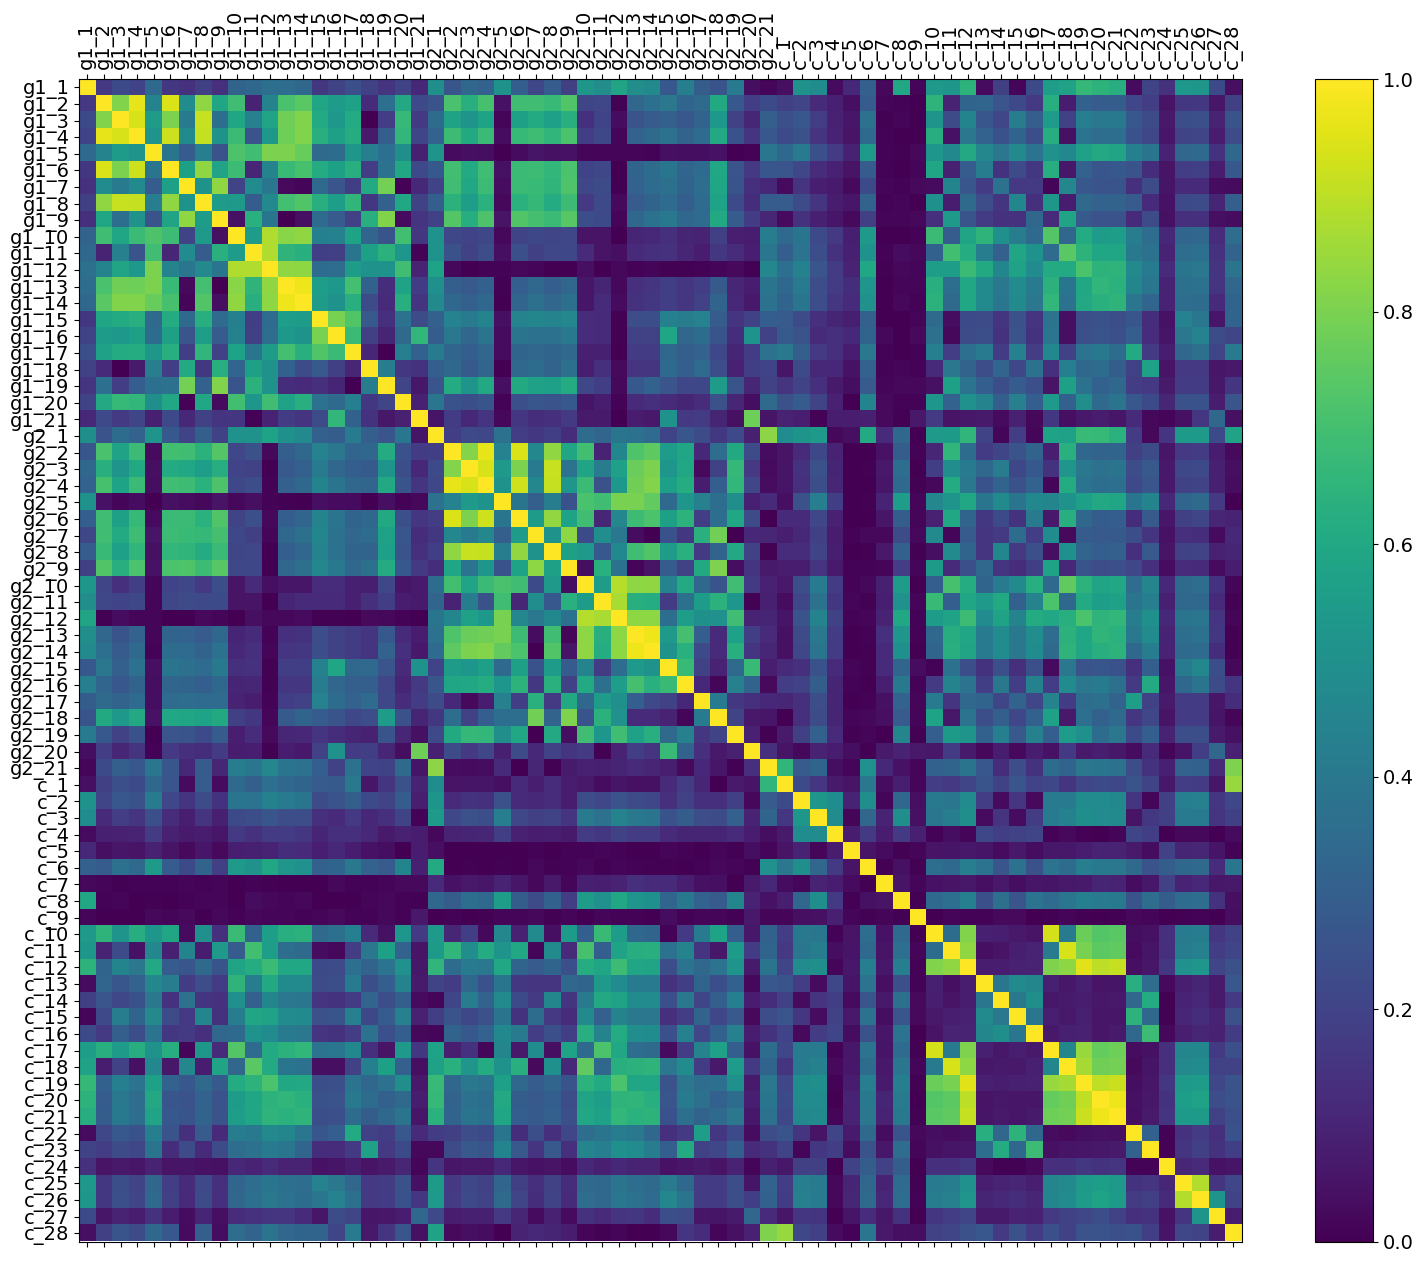

In [70]:
corr = df.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(corr.abs(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Wartość bezwzględna z korelacji Pearsona', fontsize=14)
plt.show(f)

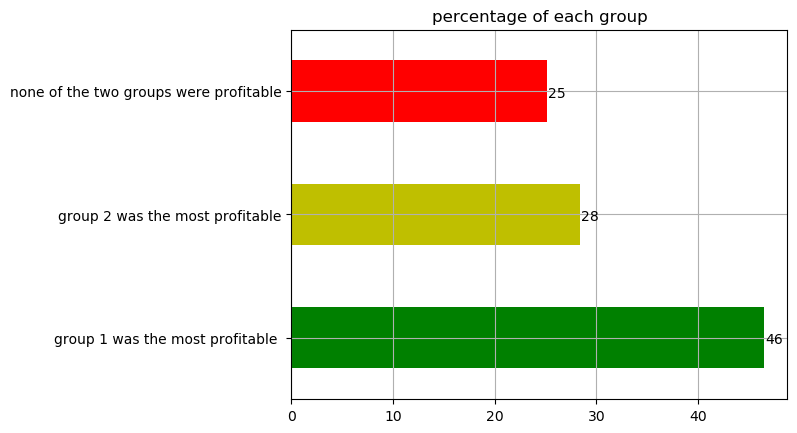

In [71]:
from itertools import cycle, islice

target_vis = df.target.value_counts(normalize=True)*100
target_vis = target_vis.rename({0: 'none of the two groups were profitable', 1: 'group 1 was the most profitable ', 2: 'group 2 was the most profitable'})
my_colors = list(islice(cycle(['g', 'y', 'r']), None, len(df)))
ax = target_vis.plot.barh(title='percentage of each group', grid = True, color = my_colors)
for p in ax.patches:
    ax.annotate(str(int(p.get_width())), (p.get_width() + 0.1, p.get_y() + 0.2,))


In [87]:
df = df.drop(['g1_21', 'g2_21', 'c_28'], axis = 1, errors='ignore')
Y = df['target']

from sklearn.preprocessing import MinMaxScaler



X = df.drop(['target'],axis=1)
trans = MinMaxScaler()
X_trans = trans.fit_transform(X)
X_train, X_valid,Y_train,Y_valid = train_test_split(X_trans, Y, test_size = 0.25)